In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from pycaret.classification import *
from imblearn.under_sampling import RandomUnderSampler

# Display all columns and rows
pd.set_option('display.max_columns', None)

In [2]:
# Load application data
train_data = pd.read_csv('/home/ignatiusvmk/Downloads/home-credit-default-risk/application_train.csv')
test_data = pd.read_csv('/home/ignatiusvmk/Downloads/home-credit-default-risk/application_test.csv')

# Checking the target variable distribution
train_data['TARGET'].value_counts(normalize=True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

In [3]:
null_percentage =  train_data.isnull().mean()*100
# Display the DataFrame before cleaning
print(f"Train Data original shape: {train_data.shape}")

Train Data original shape: (307511, 122)


In [4]:
null_percentage =  test_data.isnull().mean()*100

# Display the DataFrame before cleaning
print(f"Test Data original shape: {test_data.shape}")

Test Data original shape: (48744, 121)


In [5]:
test_null = null_percentage >= 35

In [6]:
#columns count with  >= 35% null values
print(f"Total columns with >= 35% null values: {test_null[test_null].count()}")

Total columns with >= 35% null values: 49


In [7]:
# Load bureau data
bureau = pd.read_csv('/home/ignatiusvmk/Downloads/home-credit-default-risk/bureau.csv')

# Load bureau balance data
bureau_balance = pd.read_csv('/home/ignatiusvmk/Downloads/home-credit-default-risk/bureau_balance.csv')

# Load POS_CASH_balance data
pos_cash_balance = pd.read_csv('/home/ignatiusvmk/Downloads/home-credit-default-risk/POS_CASH_balance.csv')

# Load credit card balance data
credit_card_balance = pd.read_csv('/home/ignatiusvmk/Downloads/home-credit-default-risk/credit_card_balance.csv')

# Load installments payments data
installments_payments = pd.read_csv('/home/ignatiusvmk/Downloads/home-credit-default-risk/installments_payments.csv')

In [8]:
# Sum and mean of credit amount
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'AMT_CREDIT_SUM': ['sum', 'median'],
    'CREDIT_DAY_OVERDUE': ['max'],
    'DAYS_CREDIT': ['mean'],
}).reset_index()

# Rename the columns
bureau_agg.columns = ['SK_ID_CURR', 'CREDIT_SUM_TOTAL', 'CREDIT_SUM_MEAN', 'CREDIT_OVERDUE_MAX', 'CREDIT_DURATION_MEAN']
bureau_agg.head()

,SK_ID_CURR,CREDIT_SUM_TOTAL,CREDIT_SUM_MEAN,CREDIT_OVERDUE_MAX,CREDIT_DURATION_MEAN
0,100001,1453365.000,168345.00,0,-735.000000
1,100002,865055.565,54130.50,0,-874.000000
2,100003,1017400.500,92576.25,0,-1400.750000
3,100004,189037.800,94518.90,0,-867.000000
4,100005,657126.000,58500.00,0,-190.666667


In [9]:
# Merge with train data
train_data = train_data.merge(bureau_agg, on='SK_ID_CURR', how='left')
test_data = test_data.merge(bureau_agg, on='SK_ID_CURR', how='left')

In [10]:
# Replace categorical values with numeric ones
bureau_balance['STATUS'] = bureau_balance['STATUS'].replace(['C', '0'], 0).replace(['1', '2', '3', '4', '5'], 1)

# Convert the STATUS column to numeric to handle any unexpected non-numeric values
bureau_balance['STATUS'] = pd.to_numeric(bureau_balance['STATUS'], errors='coerce')

# Group by SK_ID_BUREAU and aggregate status as sum (missed payments) and count (total months)
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
    'STATUS': ['sum', 'count']
}).reset_index()

# Rename the columns
bureau_balance_agg.columns = ['SK_ID_BUREAU', 'MISSED_PAYMENTS', 'TOTAL_MONTHS']

bureau_balance_agg.head()

,SK_ID_BUREAU,MISSED_PAYMENTS,TOTAL_MONTHS
0,5001709,0.0,86
1,5001710,0.0,53
2,5001711,0.0,3
3,5001712,0.0,19
4,5001713,0.0,0


In [11]:
# Count of active loans
pos_cash_agg = pos_cash_balance.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': 'count',  # Count of months with POS loans
    'SK_DPD': ['mean', 'sum'],  # Delay in payment (mean and total)
}).reset_index()

# Rename columns
pos_cash_agg.columns = ['SK_ID_CURR', 'POS_LOANS_COUNT', 'POS_DPD_MEAN', 'POS_DPD_TOTAL']

# Merge with train and test data
train_data = train_data.merge(pos_cash_agg, on='SK_ID_CURR', how='left')
test_data = test_data.merge(pos_cash_agg, on='SK_ID_CURR', how='left')

In [12]:
# Average balance over time
credit_card_agg = credit_card_balance.groupby('SK_ID_CURR').agg({
    'AMT_BALANCE': ['mean', 'max'],
    'MONTHS_BALANCE': 'count'
}).reset_index()

# Rename columns
credit_card_agg.columns = ['SK_ID_CURR', 'CREDIT_BALANCE_MEAN', 'CREDIT_BALANCE_MAX', 'CREDIT_CARD_MONTHS']

# Merge with train and test data
train_data = train_data.merge(credit_card_agg, on='SK_ID_CURR', how='left')
test_data = test_data.merge(credit_card_agg, on='SK_ID_CURR', how='left')

In [13]:
# Total and mean of payments
installments_agg = installments_payments.groupby('SK_ID_CURR').agg({
    'AMT_PAYMENT': ['sum', 'mean'],
    'DAYS_INSTALMENT': 'count'
}).reset_index()

# Rename columns
installments_agg.columns = ['SK_ID_CURR', 'PAYMENT_TOTAL', 'PAYMENT_MEAN', 'TOTAL_INSTALLMENTS']

# Merge with train and test data
train_data = train_data.merge(installments_agg, on='SK_ID_CURR', how='left')
test_data = test_data.merge(installments_agg, on='SK_ID_CURR', how='left')

In [14]:
train_null_percentage =  train_data.isnull().mean()*100

train_null = train_null_percentage >= 35

#columns count with  >= 35% null values
print(f"Total columns with >= 35% null values: {train_null[train_null].count()}")

Total columns with >= 35% null values: 52


In [15]:
train_data.TARGET.value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [16]:
X = train_data.drop(columns=['TARGET'])
y = train_data['TARGET']

# Initializing the RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Downsample the majority class
X_res, y_res = rus.fit_resample(X, y)

# Combine the resampled into a single DataFrame
train_data_resampled = pd.concat([X_res, y_res], axis=1)

In [17]:
train_data_resampled.TARGET.value_counts()

TARGET
0    24825
1    24825
Name: count, dtype: int64

In [18]:
train_data_resampled.shape

(49650, 135)

In [19]:
train_data_resampled = train_data_resampled.drop(columns=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                                                          'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
                                                          'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
                                                          'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
                                                          'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
                                                          'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'
                                                          ])

---
# Remove Outliers
---

* The `remove_outliers` function in PyCaret allows you to identify and remove outliers from the dataset before training the model.
* It can be achieved using `remove_outliers` parameter within `setup()`. The proportion of outliers are controlled through outliers_threshold parameter.

In [20]:
train = setup(data=train_data_resampled, target="TARGET", remove_outliers = True)

,Description,Value
0,Session id,1714
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(49650, 112)"
4,Transformed data shape,"(47912, 174)"
5,Transformed train set shape,"(33017, 174)"
6,Transformed test set shape,"(14895, 174)"
7,Numeric features,95
8,Categorical features,16
9,Rows with missing values,98.5%


In [21]:
# compare baseline models
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.6586,0.7162,0.6532,0.6603,0.6567,0.3172,0.3172,21.1980
gbc,Gradient Boosting Classifier,0.6520,0.7080,0.6511,0.6523,0.6517,0.3039,0.3040,17.3850
ada,Ada Boost Classifier,0.6489,0.7000,0.6483,0.6491,0.6487,0.2978,0.2979,3.8380
lda,Linear Discriminant Analysis,0.6426,0.6918,0.6509,0.6403,0.6455,0.2851,0.2852,1.8550
ridge,Ridge Classifier,0.6416,0.6921,0.6473,0.6401,0.6437,0.2832,0.2833,1.2730
xgboost,Extreme Gradient Boosting,0.6416,0.6930,0.6403,0.6420,0.6412,0.2833,0.2833,3.0270
rf,Random Forest Classifier,0.6372,0.6860,0.6141,0.6440,0.6286,0.2744,0.2747,7.0160
et,Extra Trees Classifier,0.6237,0.6671,0.6022,0.6292,0.6154,0.2473,0.2476,7.2710
lr,Logistic Regression,0.5971,0.6324,0.5943,0.5976,0.5959,0.1941,0.1942,11.9310
nb,Naive Bayes,0.5865,0.6207,0.6574,0.5758,0.6138,0.1730,0.1749,1.3120


In [32]:
help(plot_model)

Help on function plot_model in module pycaret.classification.functional:

plot_model(estimator, plot: str = 'auc', scale: float = 1, save: bool = False, fold: Union[int, Any, NoneType] = None, fit_kwargs: Optional[dict] = None, plot_kwargs: Optional[dict] = None, groups: Union[str, Any, NoneType] = None, verbose: bool = True, display_format: Optional[str] = None) -> Optional[str]
    This function analyzes the performance of a trained model on holdout set.
    It may require re-training the model in certain cases.
    
    Example
    -------
    >>> from pycaret.datasets import get_data
    >>> juice = get_data('juice')
    >>> from pycaret.classification import *
    >>> exp_name = setup(data = juice,  target = 'Purchase')
    >>> lr = create_model('lr')
    >>> plot_model(lr, plot = 'auc')
    
    
    estimator: scikit-learn compatible object
        Trained model object
    
    
    plot: str, default = 'auc'
        List of available plots (ID - Name):
    
        * 'pipeline'

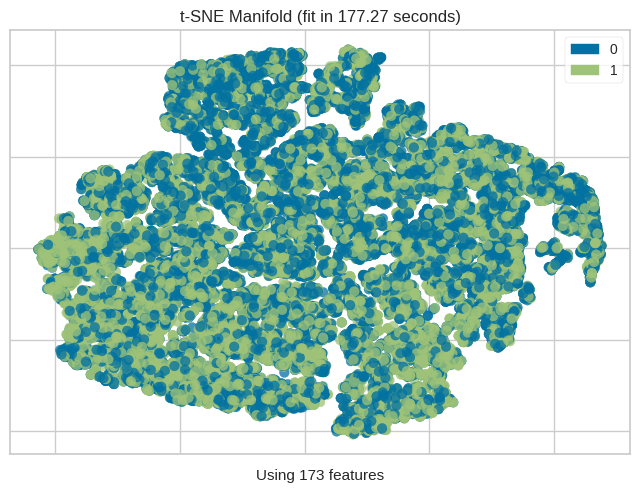

In [35]:
plot_model(best_model, plot='manifold')

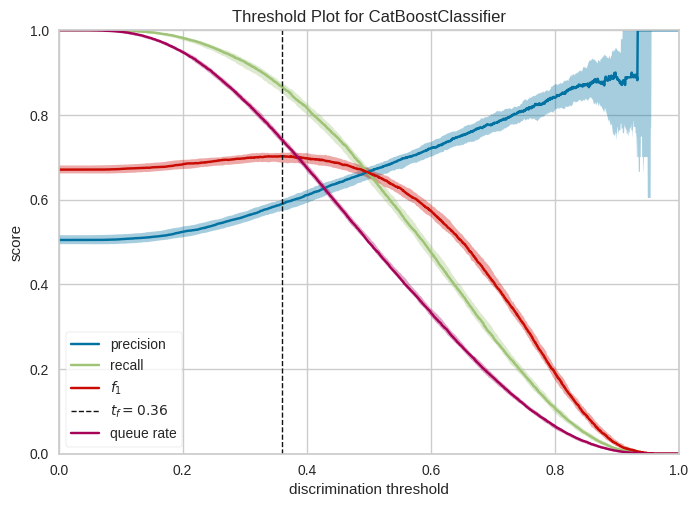

In [22]:
# Plot Discrimination Threshold
plot_model(best_model, plot='threshold')

---
# Classification: ROC and AUC
---
### *Receiver-Operatng Characteristic Curve*
> The ROC Curve is a visual reresentation of model perfomance across all thresholds

##### ROC can be quantified using AUC

---

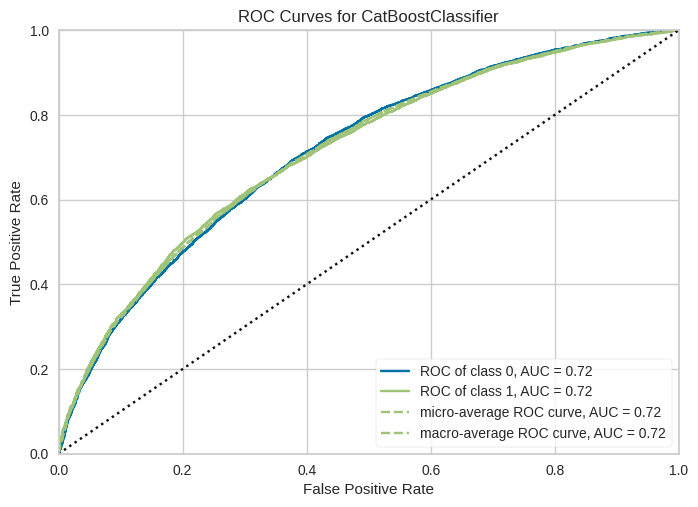

In [23]:
# Plot Area Under the Curve.
plot_model(best_model, plot='auc')

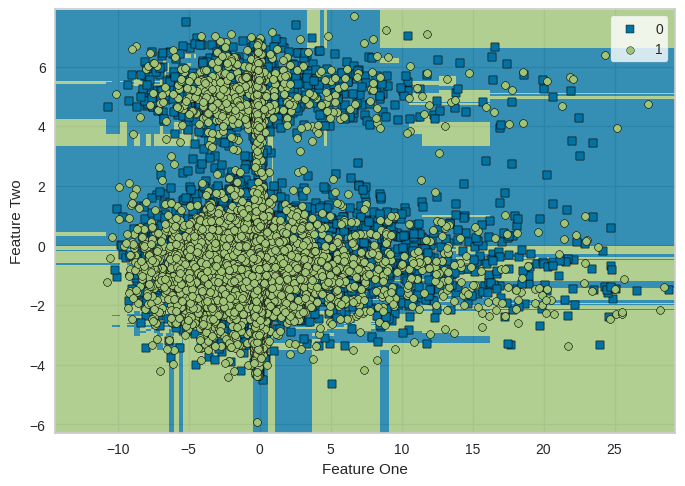

In [24]:
#  Decision Boundary
plot_model(best_model, plot='boundary')

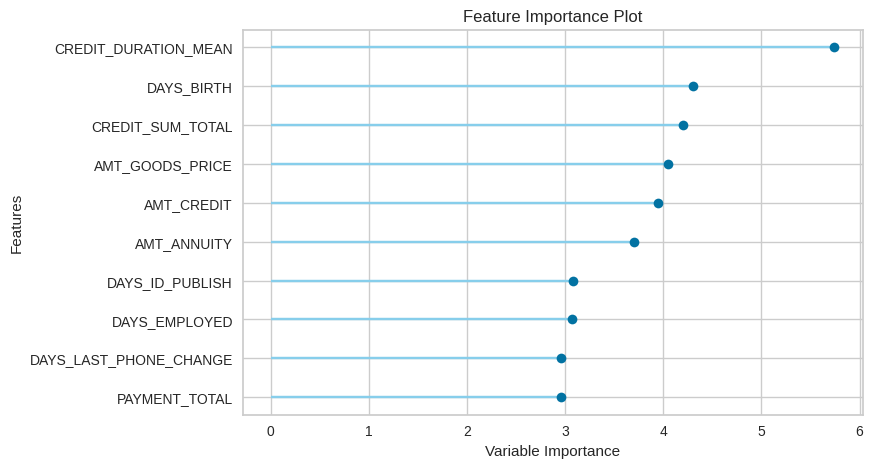

In [25]:
# Plot feature importance
plot_model(best_model, plot='feature')

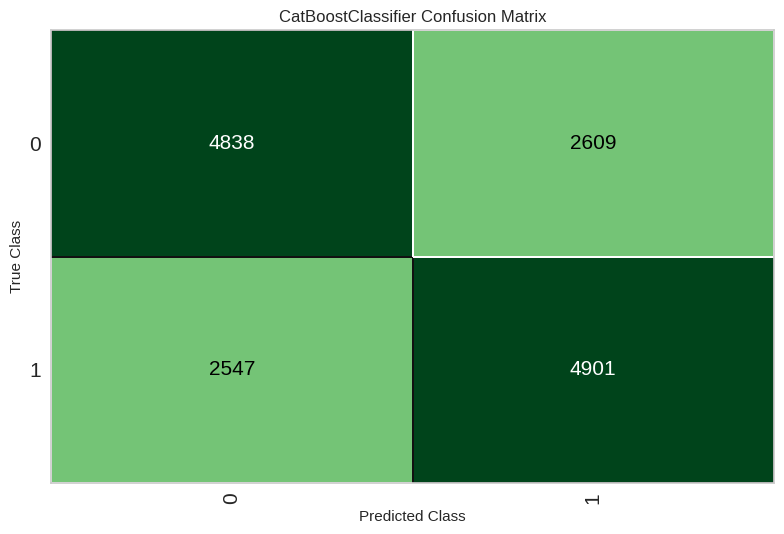

In [26]:
# Plot Confusion Matrix
plot_model(best_model, plot='confusion_matrix')

In [27]:
# Retrieve feature importance as a DataFrame
importance = pull()
importance

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.6586,0.7162,0.6532,0.6603,0.6567,0.3172,0.3172,21.198
gbc,Gradient Boosting Classifier,0.6520,0.7080,0.6511,0.6523,0.6517,0.3039,0.3040,17.385
ada,Ada Boost Classifier,0.6489,0.7000,0.6483,0.6491,0.6487,0.2978,0.2979,3.838
lda,Linear Discriminant Analysis,0.6426,0.6918,0.6509,0.6403,0.6455,0.2851,0.2852,1.855
ridge,Ridge Classifier,0.6416,0.6921,0.6473,0.6401,0.6437,0.2832,0.2833,1.273
xgboost,Extreme Gradient Boosting,0.6416,0.6930,0.6403,0.6420,0.6412,0.2833,0.2833,3.027
rf,Random Forest Classifier,0.6372,0.6860,0.6141,0.6440,0.6286,0.2744,0.2747,7.016
et,Extra Trees Classifier,0.6237,0.6671,0.6022,0.6292,0.6154,0.2473,0.2476,7.271
lr,Logistic Regression,0.5971,0.6324,0.5943,0.5976,0.5959,0.1941,0.1942,11.931
nb,Naive Bayes,0.5865,0.6207,0.6574,0.5758,0.6138,0.1730,0.1749,1.312


In [28]:
predictions = predict_model(best_model, data=test_data)

# Submission Format
---
> For each `SK_ID_CURR` in the test set, you must predict a probability for the `TARGET` variable.

* The file should contain a header and have the following format:

`SK_ID_CURR,TARGET`
1. `100001,0.1`
2. `100005,0.9`
3. `100013,0.2`


In [29]:
selected_preds = predictions [['SK_ID_CURR','prediction_label', 'prediction_score']]

In [30]:
selected_preds

,SK_ID_CURR,prediction_label,prediction_score
0,100001,1,0.5022
1,100005,1,0.7757
2,100013,0,0.7962
3,100028,0,0.7131
4,100038,1,0.6875
...,...,...,...
48739,456221,0,0.6082
48740,456222,1,0.5976
48741,456223,0,0.5892
48742,456224,0,0.6705


In [31]:
save_model(best_model, 'credit_default_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['SK_ID_CURR', 'CNT_CHILDREN',
                                              'AMT_INCOME_TOTAL', 'AMT_CREDIT',
                                              'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                                              'REGION_POPULATION_RELATIVE',
                                              'DAYS_BIRTH', 'DAYS_EMPLOYED',
                                              'DAYS_REGISTRATION',
                                              'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
                                              'FLAG_MOBIL', 'FLAG_EMP_PHONE',
                                              'FLAG_WORK_...
                                                               handle_missing='return_nan',
                                                               handle_unknown='value',
                